In [1]:
%pip install uv
!uv pip install --system evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 87.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
Using Python 3.10.12 environment at: /usr
Resolved 35 packages in 804ms                                        
⠙ Preparing packages... (0/3)                                                   
⠙ Preparing packages... (0/3)----     0 B/82.04 KiB                     
⠙ Preparing packages... (0/3)---- 16.00 KiB/82.04 KiB                   
⠙ Preparing packages... (0/3)---- 32.00 KiB/82.04 KiB                   
⠙ Preparing packages... (0/3)---- 48.00 KiB/82.04 KiB                   
⠙ Preparing packages... (0/3)---- 64.00 KiB/82.04 KiB                   
jiwer      ------------------------------     0 B/21.47 KiB
⠙ Preparing packages... (0/3)---- 64.00 KiB/82.04 KiB                   
jiwer      ------------------------------     0 B/21.47 KiB
⠙ Preparing packages... (0/3) 80.00 KiB/82.04 KiB                   
jiwer      -------------

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from PIL import Image
import evaluate
import os
from tqdm.notebook import tqdm, trange

In [3]:
import torch
from torch.utils.data import *
from torch import nn, optim
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, TrOCRConfig
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [4]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed', )
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-printed')

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
df = pd.read_excel('/kaggle/input/captchas-qt/generated.xlsx')
df.drop(['GENERATED'], axis=1, inplace=True)
df.dropna(how='any', inplace=True)
print(df.shape)
df.head()

(1952, 2)


,FILE_NAME,CAPTCHA_VALUE
0,captcha_1.png,Hi7qA
1,captcha_10.png,2aBiC
2,captcha_100.png,7GksP
3,captcha_1000.png,t3QgL
4,captcha_1001.png,b5tGL


In [6]:
image_root = Path("/kaggle/input/captchas-qt/captchas")
images = sorted(image_root.glob("*.png"))
len(images)

2000

In [7]:
image = Image.open(image_root / 'captcha_1.png')
pixel_values = processor(images=image, return_tensors='pt').pixel_values
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [8]:
class CaptchaDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return df.shape[0]

    def __getitem__(self, idx):
        file_name, text = self.df.iloc[idx, 0], self.df.iloc[idx, 1]

        image = Image.open(image_root / file_name)
        pixel_values = processor(image, return_tensors="pt").pixel_values
        labels = processor.tokenizer(text, padding="max_length", max_length=20).input_ids
        labels = np.asanyarray(labels)
        labels[labels == processor.tokenizer.pad_token_id] = -100
        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.from_numpy(labels).long()
        }

In [9]:
dataset = CaptchaDataset(df)
dataset[0]

{'pixel_values': tensor([[[0.5373, 0.5373, 0.5373,  ..., 0.7725, 0.7725, 0.7725],
          [0.5373, 0.5373, 0.5373,  ..., 0.7725, 0.7725, 0.7725],
          [0.5373, 0.5373, 0.5373,  ..., 0.7725, 0.7725, 0.7725],
          ...,
          [0.7961, 0.7961, 0.7961,  ..., 0.7725, 0.7725, 0.7725],
          [0.8039, 0.8039, 0.8039,  ..., 0.7725, 0.7725, 0.7725],
          [0.8039, 0.8039, 0.8039,  ..., 0.7725, 0.7725, 0.7725]],
 
         [[0.6627, 0.6627, 0.6627,  ..., 0.7725, 0.7725, 0.7725],
          [0.6627, 0.6627, 0.6627,  ..., 0.7725, 0.7725, 0.7725],
          [0.6627, 0.6627, 0.6627,  ..., 0.7725, 0.7725, 0.7725],
          ...,
          [0.7804, 0.7804, 0.7804,  ..., 0.7725, 0.7725, 0.7725],
          [0.7804, 0.7804, 0.7804,  ..., 0.7725, 0.7725, 0.7725],
          [0.7882, 0.7882, 0.7882,  ..., 0.7725, 0.7725, 0.7725]],
 
         [[0.7255, 0.7255, 0.7255,  ..., 0.7725, 0.7725, 0.7725],
          [0.7255, 0.7255, 0.7255,  ..., 0.7725, 0.7725, 0.7725],
          [0.7255, 0.725

In [10]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [11]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_new_tokens = 20
model.config.early_stopping = True

model.config.length_penalty = 2.0
model.config.num_beams = 2

In [12]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    fp16=True, 
    output_dir="./",
    logging_steps=1,
    save_steps=1000,
    eval_steps=100,
    num_train_epochs=10,
    report_to="none",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
cer_metric = evaluate.load("cer", trust_remote_code=True)

In [14]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [16]:
from transformers import default_data_collator
os.environ["WANDB_DISABLED"] = "true"

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Step,Training Loss,Validation Loss,Cer
100,0.051700,0.116207,0.019437
200,0.049000,0.116383,0.023529
300,0.004000,0.093163,0.015857


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 2, 'length_penalty': 2.0}


TrainOutput(global_step=330, training_loss=0.11170911319610295, metrics={'train_runtime': 500.2065, 'train_samples_per_second': 31.207, 'train_steps_per_second': 0.66, 'total_flos': 1.867341370616709e+18, 'train_loss': 0.11170911319610295, 'epoch': 10.0})

In [17]:
trained_model = VisionEncoderDecoderModel.from_pretrained('checkpoint-330')

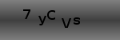

In [18]:
image = Image.open("/kaggle/input/captchas-qt/captchas/captcha_101.png").convert("RGB")
image

In [19]:
def rec(image):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to('cuda')
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [20]:
rec(image)

'7yCVs'

In [21]:
values = []

for idx in trange(df.shape[0]):
    fname = df.iloc[idx, 0]
    value = rec(Image.open(image_root / fname))
    values.append(value)

  0%|          | 0/1952 [00:00<?, ?it/s]

In [22]:
df['GENERATED_VALUE'] = values
df.head()

,FILE_NAME,CAPTCHA_VALUE,GENERATED_VALUE
0,captcha_1.png,Hi7qA,Hi7qA
1,captcha_10.png,2aBiC,2aBiC
2,captcha_100.png,7GksP,7GksP
3,captcha_1000.png,t3QgL,t3QgL
4,captcha_1001.png,b5tGL,b5tGL


In [23]:
invalid = df[(df['CAPTCHA_VALUE'] != df['GENERATED_VALUE'])]
print(len(invalid))
invalid

39


,FILE_NAME,CAPTCHA_VALUE,GENERATED_VALUE
90,captcha_108.png,S7jKr,S7jkr
137,captcha_1121.png,E6pZi,E6pZj
169,captcha_1150.png,UdU6n,UdUGn
203,captcha_1181.png,m9XyJ,m9XYJ
209,captcha_1187.png,bAq5x,bAq5X
217,captcha_1194.png,4QBKi,4QBki
297,captcha_1266.png,LtJc2,LtJC2
343,captcha_1307.png,1iGcH,1iGct
401,captcha_136.png,5jiCE,5jCE
414,captcha_1371.png,kuc5H,Xuc5H


In [24]:
df.to_excel("new_captcha_values.xlsx")

In [28]:
!du -sh checkpoint-330/*

8.0K	checkpoint-330/config.json
4.0K	checkpoint-330/generation_config.json
236M	checkpoint-330/model.safetensors
470M	checkpoint-330/optimizer.pt
4.0K	checkpoint-330/preprocessor_config.json
16K	checkpoint-330/rng_state.pth
4.0K	checkpoint-330/scheduler.pt
60K	checkpoint-330/trainer_state.json
8.0K	checkpoint-330/training_args.bin


In [30]:
(df['CAPTCHA_VALUE'] == df['GENERATED_VALUE']).mean()

0.9800204918032787

In [34]:
I = torch.randn(1, 3, 384, 384)
O = model.cpu().generate(I)

In [45]:
inputs = processor(image, return_tensors="pt")
input_ids = inputs.pixel_values

In [51]:
model

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(